## Tutorial for training ML models with nanopore data for site-specific ψ quantification

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import sys
import os
import pandas as pd
from sklearn import preprocessing
import sklearn as sk
import scipy
print('The numpy version is {}.'.format(np.__version__))
print('The scikit-learn version is {}.'.format(sk.__version__))
print('The pandas version is {}.'.format(pd.__version__))
print('The scipy version is {}.'.format(scipy.__version__))
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix


from sklearn.metrics import RocCurveDisplay
from matplotlib import gridspec
import matplotlib.patches as mpatches
import matplotlib.font_manager
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import MultipleLocator
import matplotlib as mpl
from matplotlib import colors
print("######")
#from ModQuant import ML_helpers 
import ML_helpers 

The numpy version is 1.23.5.
The scikit-learn version is 1.1.1.
The pandas version is 1.4.2.
The scipy version is 1.10.0.
######
The numpy version is 1.23.5.
The scikit-learn version is 1.1.1.
The pandas version is 1.4.2.
The scipy version is 1.10.0.
The python version is 3.8.16 (default, Jan 17 2023, 22:25:28) [MSC v.1916 64 bit (AMD64)].
The scikit-learn version is 1.1.1.
The numpy version is 1.23.5.
The pandas version is 1.4.2.


### Let's load a dataframe containing the training set extracted from synthetic standards called with guppy 6.3.2 with a +2/-2 feature extraction window

In [2]:
df=pd.read_pickle("prepared_training_data/MCM5_training_data_with_insertions_6.3.2_n5_11282022_141230.pkl")#MCM5
#df=pd.read_pickle("ModQuant/prepared_training_data/MRPS14_training_data_with_insertions_6.3.2_n5_11282022_14932.pkl")#MRPS14
#df=pd.read_pickle("ModQuant/prepared_training_data/PRPSAP1_training_data_with_insertions_6.3.2_n5_11282022_141510.pkl")#PRPSAP1
#df=pd.read_pickle("ModQuant/prepared_training_data/PSMB2_training_data_with_insertions_6.3.2_n5_11282022_14178.pkl")#PSMB2
#df=pd.read_pickle("ModQuant/prepared_training_data/RNF7_training_data_with_insertions_6.3.2_n5_11282022_142012.pkl")#RNF7


### Let's drop prepare the feature space for ML training and testing

In [3]:
for (columnName, columnData) in df.iteritems(): #Let's take a look at the feature names in our dataframe
    print('Column Name : ',columnName)


substrings_to_drop=['read_ID','samples','type'] #dropping columns from the dataframe that should not be in the feature space
columns_to_drop=[col for col in df.columns if any(substring in col for substring in substrings_to_drop)]

feature_prep_df=df.drop(columns=columns_to_drop)

feature_space=[]
for (columnName,columnData) in feature_prep_df.iteritems():
    print('Column Name : ', columnName)
    feature_space.append(columnName)
print(f"Number of feature dimensions: {len(feature_space)}")

print(df["type"].value_counts())


Column Name :  read_ID
Column Name :  B.n2
Column Name :  B.n1
Column Name :  B.0
Column Name :  B.p1
Column Name :  B.p2
Column Name :  Q.n2
Column Name :  Q.n1
Column Name :  Q.0
Column Name :  Q.p1
Column Name :  Q.p2
Column Name :  Insertions_Freq_A
Column Name :  Insertions_Freq_C
Column Name :  Insertions_Freq_G
Column Name :  Insertions_Freq_T
Column Name :  Total_Insertions
Column Name :  signal.mean.n2
Column Name :  signal.mean.n1
Column Name :  signal.mean.0
Column Name :  signal.mean.p1
Column Name :  signal.mean.p2
Column Name :  signal.std.n2
Column Name :  signal.std.n1
Column Name :  signal.std.0
Column Name :  signal.std.p1
Column Name :  signal.std.p2
Column Name :  signal.dt.n2
Column Name :  signal.dt.n1
Column Name :  signal.dt.0
Column Name :  signal.dt.p1
Column Name :  signal.dt.p2
Column Name :  raw.current.samples.n2
Column Name :  raw.current.samples.n1
Column Name :  raw.current.samples.0
Column Name :  raw.current.samples.p1
Column Name :  raw.current.sampl

### Let's now train and test all five supervised models with stratified 5-fold cross-validation

In [4]:
#Plotting Function for confusion matrix
from matplotlib import gridspec
import matplotlib.patches as mpatches
import matplotlib.font_manager
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import MultipleLocator
import matplotlib.cm

def plot_avg_conf_mat(ax,mat_mean,mat_std,avg_accuracy,labels,color):
    plusminus = u"\u00B1"
    ax.grid(False)
    cax = ax.matshow(mat_mean, cmap=matplotlib.cm.get_cmap(color),vmin=0,vmax=1)
    for k in range(mat_mean.shape[0]):
        for j in range(mat_mean.shape[1]):
            if k == j:
                textcolor='white'
            else:
                textcolor='k'
            ax.text(x=j, y=k,s=f"{100*mat_mean[k, j]:0.1f}{plusminus}{100*mat_std[k, j]:0.2f}%", va='center', ha='center', size='x-large', color=textcolor)
    ax.set_title(f"Mean Classification Accuracy: {avg_accuracy*100:.1f} %")
    ax.xaxis.tick_bottom()
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels, rotation="vertical",verticalalignment='center')
    plt.xlabel("Predicted")
    plt.ylabel("Expected")
    return

Overall accuracy of gbc: 0.9720185245486451
Overall accuracy of rfc: 0.9504775860197546
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Overall accuracy of svm: 0.967630341184558
Overall accuracy of logisticReg: 0.953548789753609
Overall accuracy of knn: 0.943320670067658


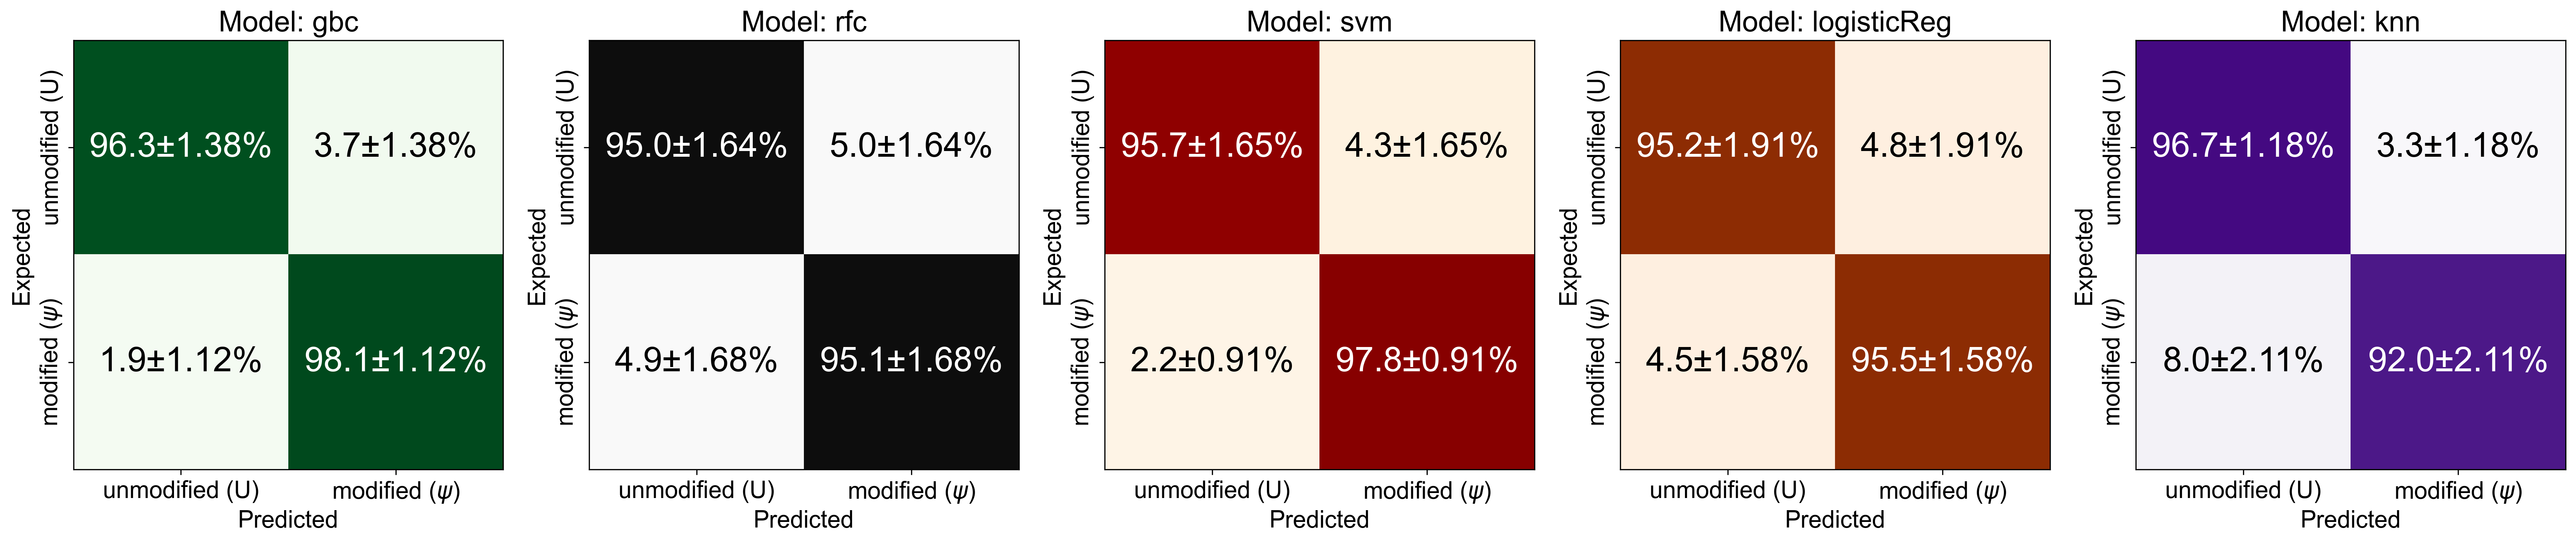

In [8]:
import warnings
warnings.filterwarnings('ignore')
disp_labels = ["unmodified (U)", "modified ($\psi$)"]
plt.rcParams['font.family'] = "arial"
matplotlib.rcParams.update({'font.size':16})


models=['gbc','rfc','svm','logisticReg','knn'] #load models we want to train and test
colors = ['Greens', 'Greys', 'OrRd', 'Oranges', 'Purples'] #colors of confusion matrix displaying overall accuracy for each model
labels=["unmodified","modified"] #labels we used in 'type' column to identify if a transcript is modified or unmodified

plt.figure(figsize=(30,10), dpi=300)
for idx, model in enumerate(models):
    ax=plt.subplot(1, 5, idx+1)
    summary_output=ML_helpers.IterateModel(df,feature_space,labels,model,seed=654).model_iter() #train and test each model iteratively
    print(f"Overall accuracy of {model}: {summary_output['avg_accuracy']}")
    plot_avg_conf_mat(ax,summary_output['avg_conf_mat_mean'],summary_output['avg_conf_mat_std'],summary_output['avg_accuracy'],disp_labels,colors[idx])
    plt.title(f"Model: {model}") #comment this out to print the overall accuracy as the title of each confusion matrix
    

### Let's now look at the accuracy of the GBC model as a function of training size

In [5]:
###Training and testing gbc model at varying sample sizes in the training set to see the overall accuracy as a function of sample size of training data###
import math

labels=["unmodified","modified"] #labels we used in 'type' column to identify if a transcript is modified or unmodified
print(f"Sample size of each type in the original training:\n{df['type'].value_counts()}")
limiting_total_size=min(df["type"].value_counts()) #Let's take the sample size of the modified data and limit our analysis to it
limiting_train_size=math.floor(limiting_total_size*0.8) #we need to save 20% of the data for testing at the maximum training size
 
model='gbc'
#model_typec='rfc'
#model_type='svm'
#model_type='logisticReg'
#model_type='knn'

s_max_log=np.log10(limiting_train_size) #log-scale the maximum training size for each sample at the end of our sweep

total_accuracy=[]
sample_sizes=np.logspace(1.5,s_max_log,25,endpoint=True) 
for sz in sample_sizes:
    sz=math.floor(sz)
    print('')
    print(f"Training sample size for each type of sample for this iteration: {sz}")
    summary_output=ML_helpers.IterateModel(df,feature_space,labels,model,seed=4321,train_sample_sz=sz).model_iter() #train and test each model iteratively
    #summary_output=model_iter(df,Syn_List,model_type,4321,0.2,5,5,25,sz) #MCM5, PSMB2
    #summary_output=model_iter(df,Syn_List,model_type,654,0.2,5,5,25,sz) #MRPS14, PRPSAP1, RNF7
    #training_sz=len(summary_output["iteration_results"][0]['x_train'])
    training_sz=len(summary_output["iteration_results"][0]['x_train'])
    test_sz=len(summary_output["test_indices"][0])
    print(f"Confirmed input training size used for these model iterations: {training_sz}")
    print(f"Confirmed input test size used for these model iterations: {test_sz}")
    print(f"Average GBC accuracy with current: {summary_output['avg_accuracy']}")
    total_accuracy.append((training_sz,summary_output["avg_accuracy"],summary_output["std_accuracy"])) #append results to list to plot
print(total_accuracy)

Sample size of each type in the original training:
unmodified    8947
modified       831
Name: type, dtype: int64

Training sample size for each type of sample for this iteration: 31
Confirmed input training size used for these model iterations: 62
Confirmed input test size used for these model iterations: 333
Average GBC accuracy with current: 0.833991461340859

Training sample size for each type of sample for this iteration: 35
Confirmed input training size used for these model iterations: 70
Confirmed input test size used for these model iterations: 333
Average GBC accuracy with current: 0.8386938745974889

Training sample size for each type of sample for this iteration: 40
Confirmed input training size used for these model iterations: 80
Confirmed input test size used for these model iterations: 333
Average GBC accuracy with current: 0.8446439813307284

Training sample size for each type of sample for this iteration: 46
Confirmed input training size used for these model iterations:

### Let's plot the results from sweeping the training size of the GBC model

[  57.  581. 1104. 1628.]


Text(0.5, 1.0, 'GBC model accuracy versus sample size of training data for $\\itMCM5$')

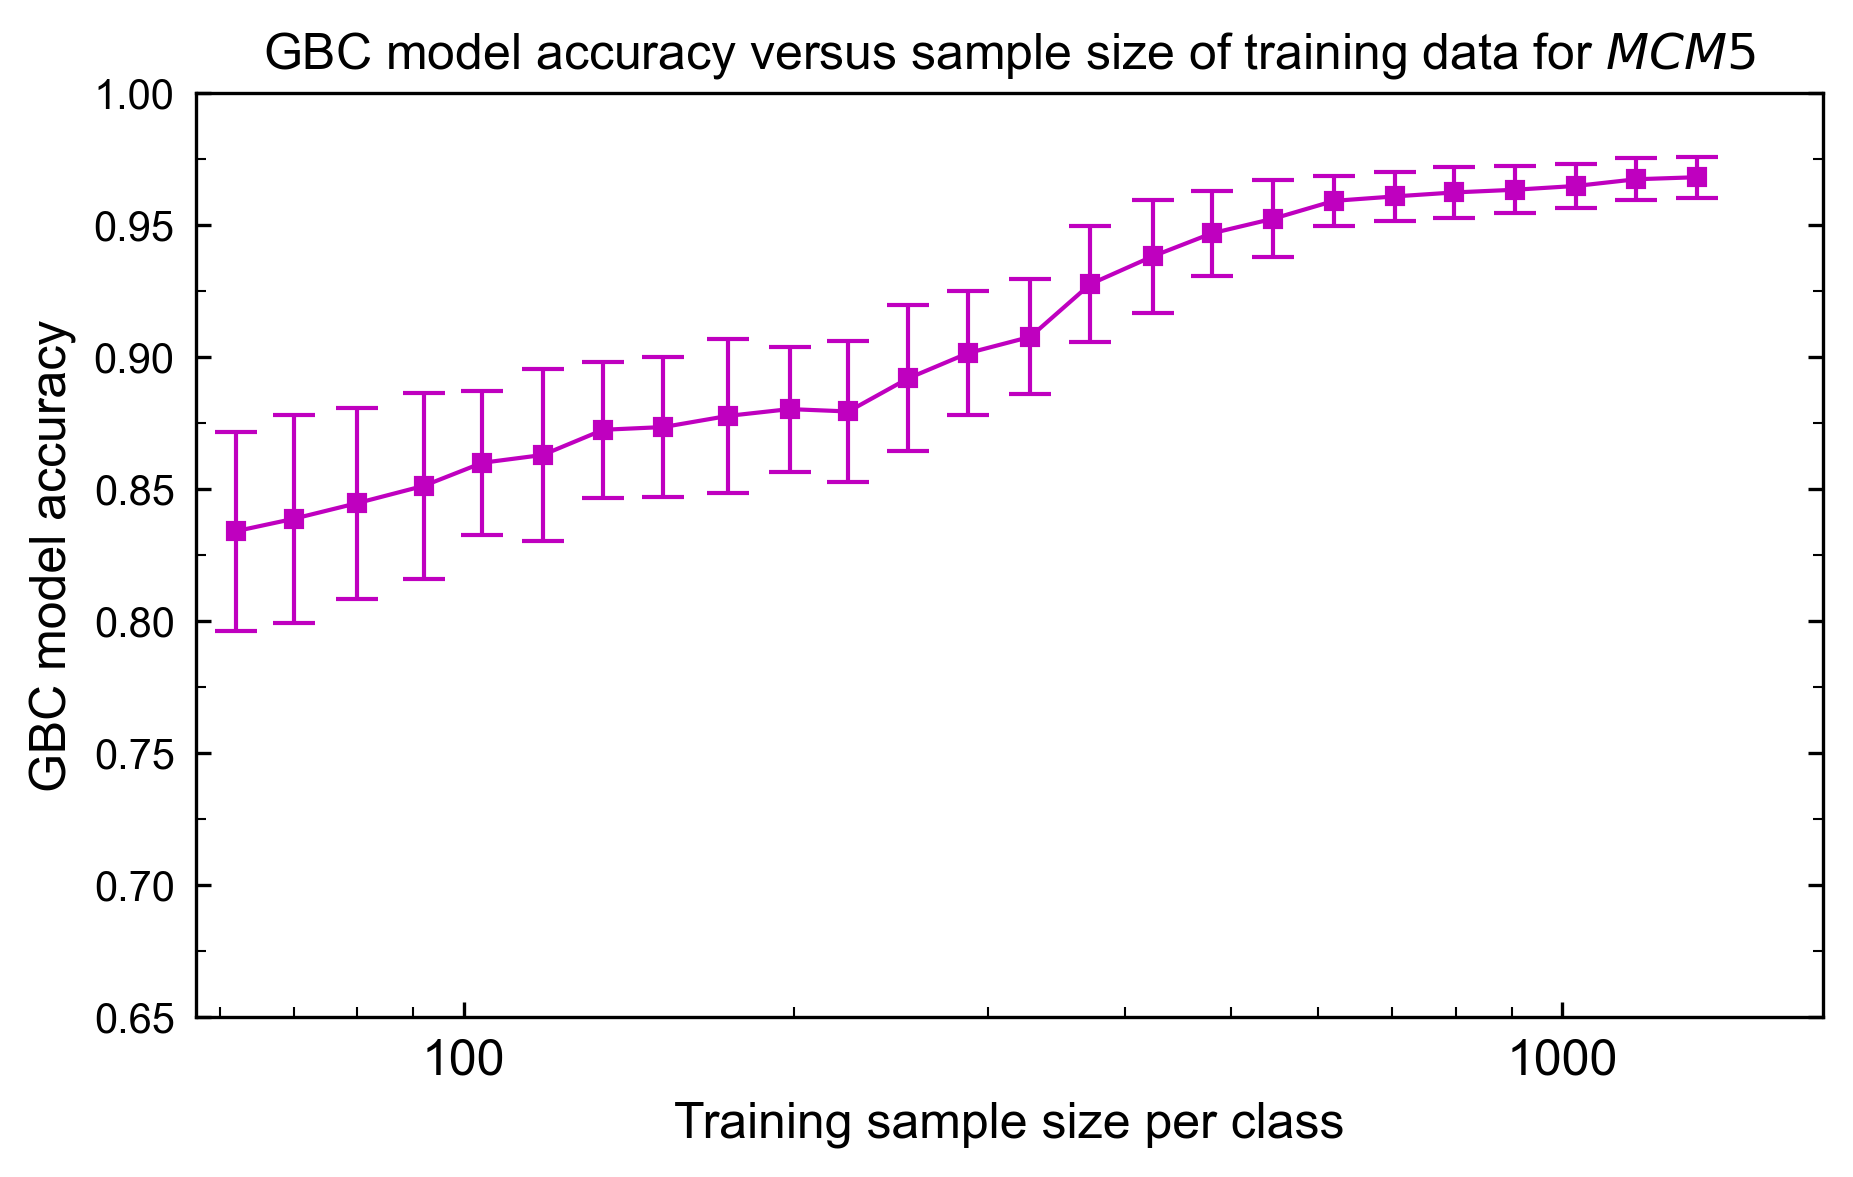

In [9]:
####Plotting model accuracy as a function of sample size for training and testing####
from sklearn.metrics import RocCurveDisplay
import seaborn as sns
from matplotlib import gridspec
import matplotlib.patches as mpatches
import matplotlib.font_manager
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import MultipleLocator
import pickle
import warnings
warnings.filterwarnings('ignore')

#gene = 'PRPSAP1'
#gene = 'PSMB2'
gene = 'MCM5'
#gene = 'MRPS14'
#gene = 'RNF7'


sample_sizes=([i[0] for i in total_accuracy])
sample_means=([i[1] for i in total_accuracy])
sample_stds=([i[2] for i in total_accuracy])

plt.rcParams['font.family'] = "arial"
fig, ax = plt.subplots(figsize=(7,4),dpi=300)
ax.yaxis.set_ticks_position('both')
ax.tick_params(axis="y",direction="in", pad=5)
ax.tick_params(axis="x",direction="in", pad=5)
minor_locator_x = AutoMinorLocator(2)
minor_locator_y = AutoMinorLocator(2)
ax.tick_params(which='minor', length=2.5, width=0.5, direction='in')
ax.xaxis.set_minor_locator(minor_locator_x)
ax.yaxis.set_minor_locator(minor_locator_y)
ax.set_ylim([0.65, 1])
ax.set_xlim([sample_sizes[0]-5, sample_sizes[-1]+400])


xlo=sample_sizes[0]-5
xhi=sample_sizes[-1]+300
x_ticks = np.linspace(xlo,xhi,4)
x_ticks = np.around(x_ticks)

print(x_ticks)
ax.set_xscale('log')
ax.set_xticklabels([str(int(x_ticks[0])),str(int(x_ticks[1])),str(int(x_ticks[2])),str(int(x_ticks[3]))], fontdict = {'fontsize' : 12})
ax.set_xlabel('Training sample size per class', fontdict = {'fontsize' : 12})
ax.set_ylabel('GBC model accuracy', fontdict = {'fontsize' : 12})

ax.set_xticklabels(['0', '1', '100', '1000'], fontdict = {'fontsize' : 12})#for MCM5 and MRPS14 and PRPSAP1
model_vs_samplesz=ax.errorbar(sample_sizes,sample_means,yerr=sample_stds,fmt='s',solid_capstyle='projecting', 
                               capsize=5,color='m',linestyle='-',lw=1, markersize=4,elinewidth=1, label=f"Target Features Only")
ax.set_title(f'GBC model accuracy versus sample size of training data for $\it{gene}$', fontdict = {'fontsize' : 12})

### Let's now train and test the GBC model as a function of ψ ratio in the test set 

In [5]:
labels=["unmodified","modified"]
summary_output_ratios=ML_helpers.IterateModel(df,feature_space,labels,'gbc',seed=4321).ratio_model_iter("modified","unmodified") #train and test each model iteratively as a function of ψ ratio in the test set

### Let's look at average relative feature importance in the form of a heatmap

In [6]:
print(f"Overall model accuracy: {summary_output_ratios['avg_accuracy']}")
print(f"Overall ranking of relative feature improtance: \n {summary_output_ratios['avg_feature_importance'].sort_values(by='Weight',ascending=False)}")

Overall model accuracy: 0.9682311226889542
Overall ranking of relative feature improtance: 
        Weight             Feature
42  49.659253  Quartile_1_kmer_p2
11  12.679334   Insertions_Freq_C
2    9.501459                 B.0
1    4.751405                B.n1
14   4.349705    Total_Insertions
39   3.136087  Quartile_1_kmer_p1
30   2.584374  Quartile_1_kmer_n2
29   2.438470        signal.dt.p2
38   0.696041   Quartile_3_kmer_0
5    0.695980                Q.n2
31   0.552889  Quartile_2_kmer_n2
34   0.533265  Quartile_2_kmer_n1
40   0.511543  Quartile_2_kmer_p1
25   0.507222        signal.dt.n2
24   0.429211       signal.std.p2
32   0.409081  Quartile_3_kmer_n2
27   0.400745         signal.dt.0
18   0.361699      signal.mean.p1
21   0.347586       signal.std.n1
41   0.343155  Quartile_3_kmer_p1
43   0.340112  Quartile_2_kmer_p2
44   0.337458  Quartile_3_kmer_p2
10   0.335020   Insertions_Freq_A
33   0.326981  Quartile_1_kmer_n1
36   0.307093   Quartile_1_kmer_0
7    0.291072          

In [ ]:
#Uncomment to save feature importance results of all model training and testing iterations
# import pickle

# #gene = 'PSMB2'
# gene = 'MCM5'
# #gene = 'PRPSAP1'
# #gene = 'MRPS14'
# #gene = 'RNF7'
# guppy_version = '6.3.2'
# kmer_window = 'n5'


# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(summary_output_ratios['avg_feature_importance'])

# file_name = f'Feature_importance_results/{gene}_{guppy_version}_{kmer_window}_GBC_avg_feature_importance_signal_only'
# with open(f'{file_name}.pkl', 'wb') as handle:
#     pickle.dump(summary_output_ratios['avg_feature_importance'], handle, protocol=pickle.HIGHEST_PROTOCOL)

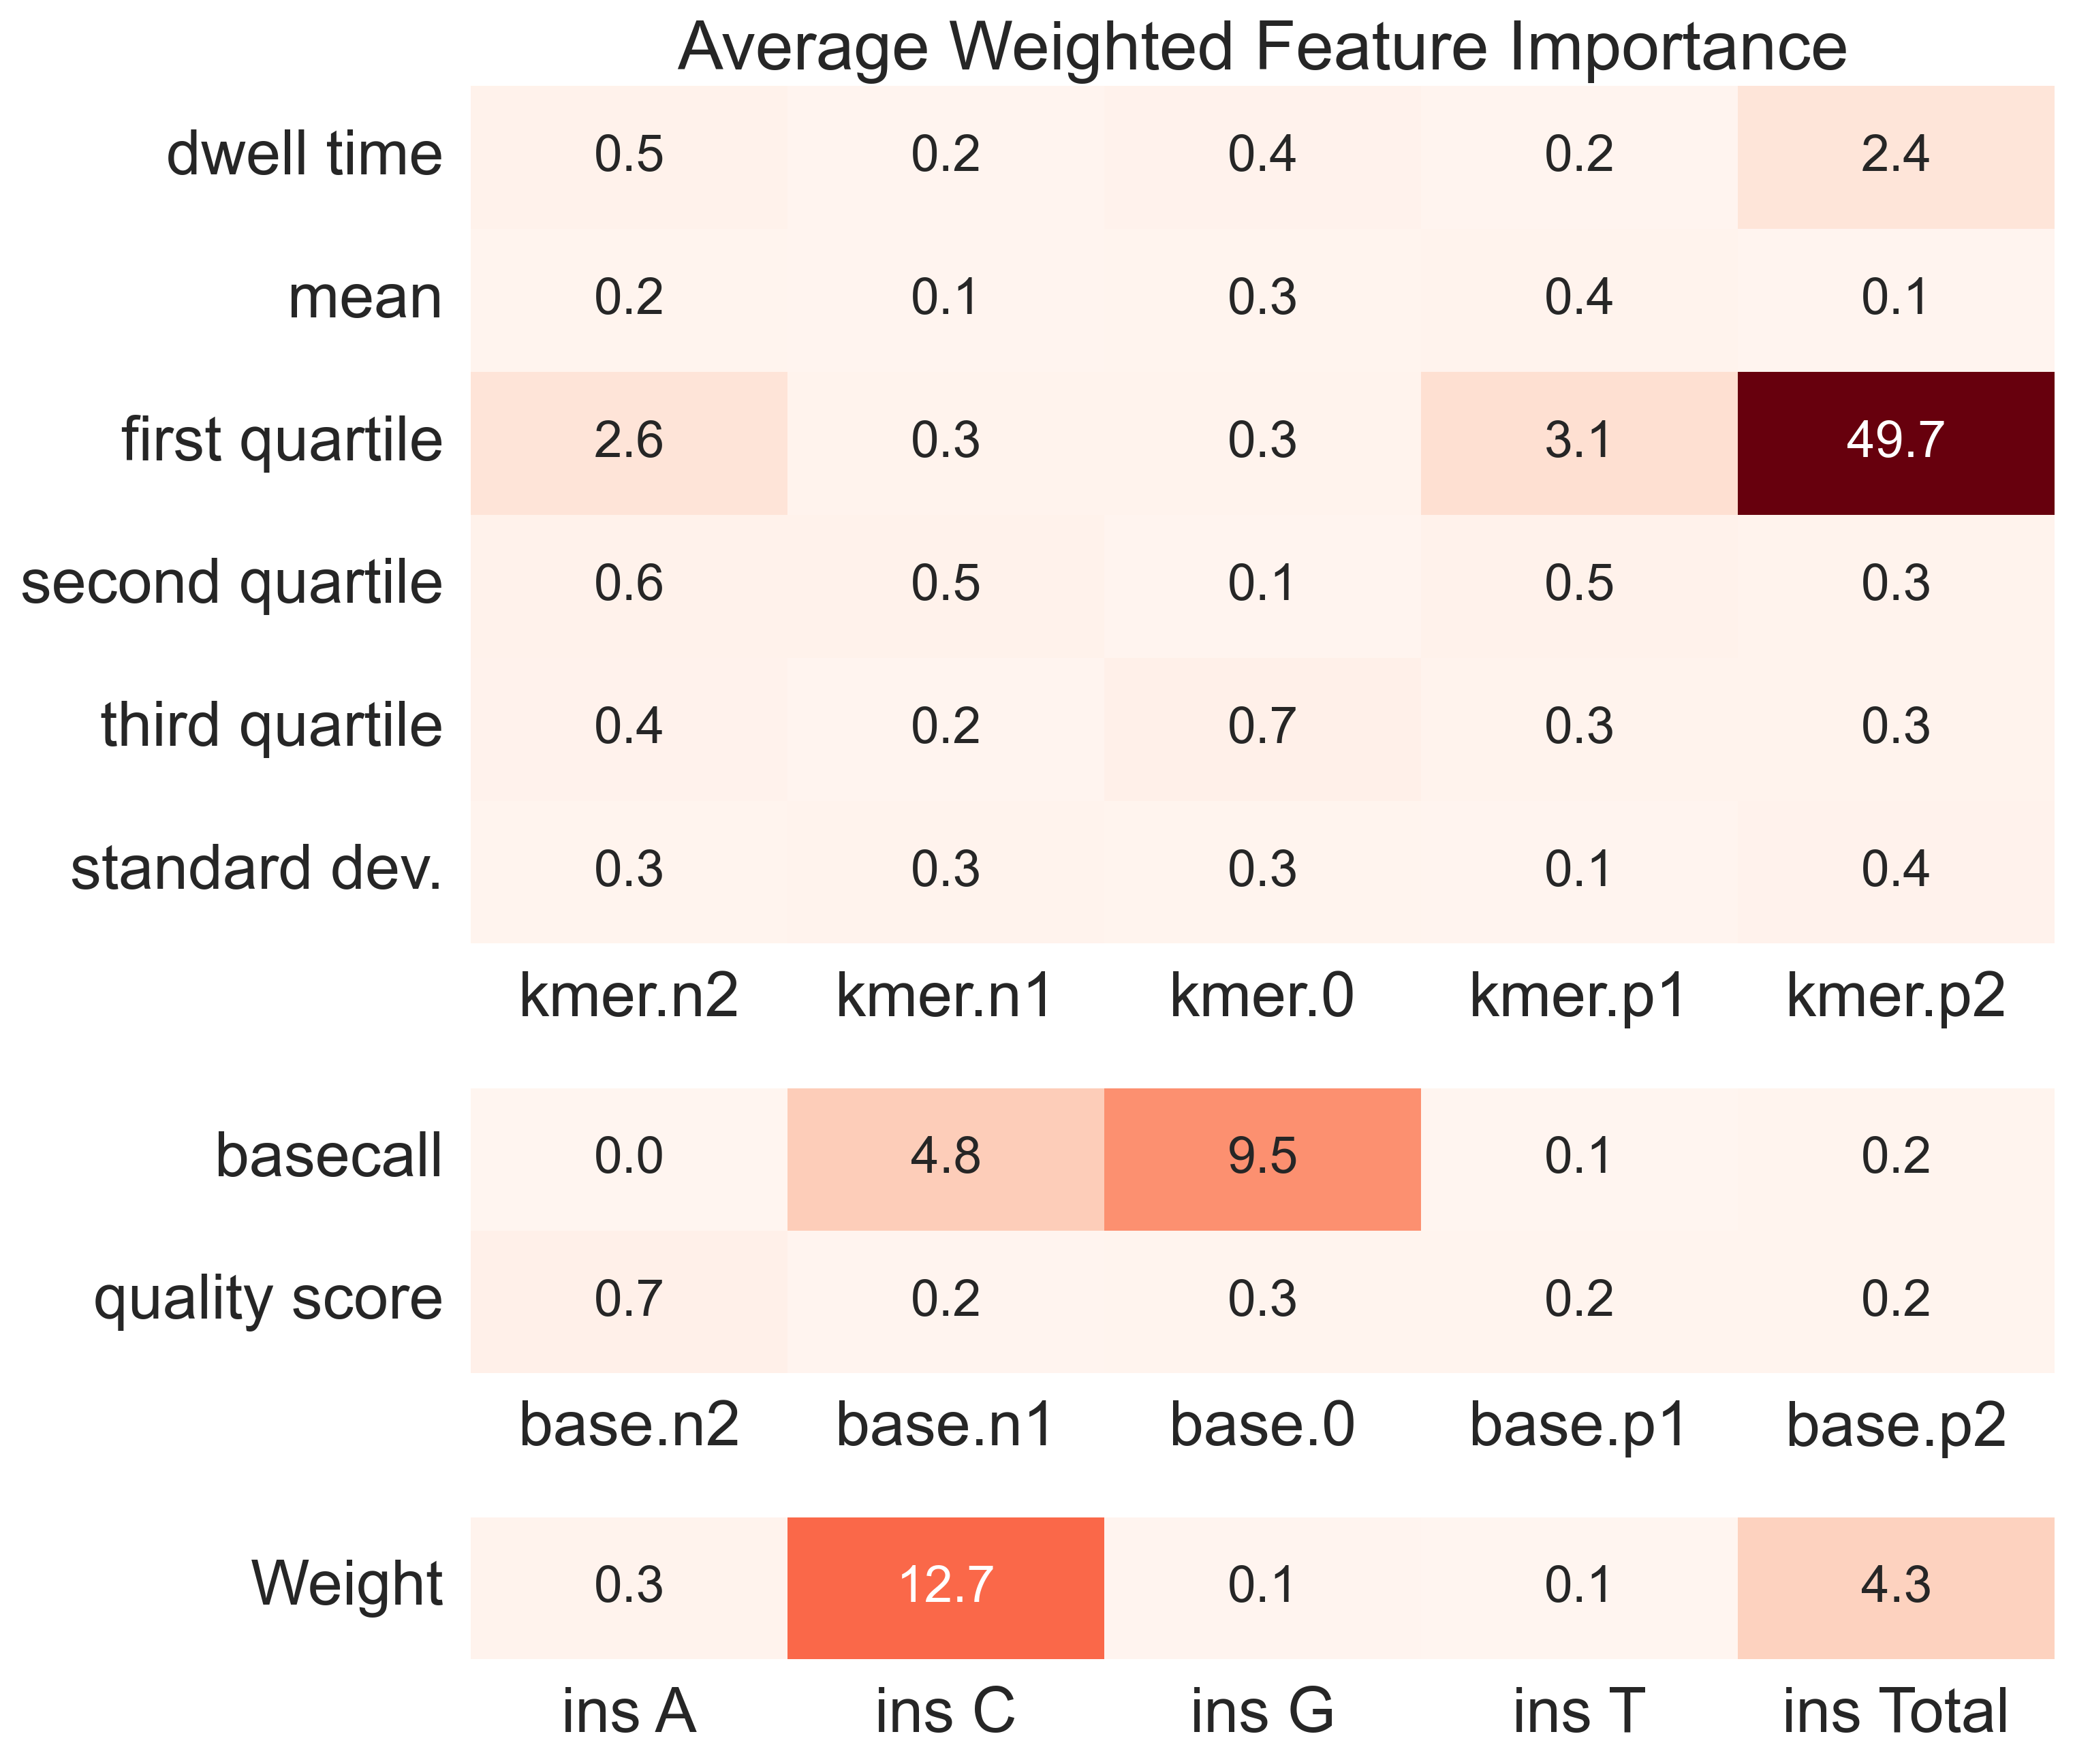

In [11]:
###Plotting heatmap for feature importance###

df=summary_output_ratios['avg_feature_importance']
df.columns=['Weight', 'Feature']
#print(df)

df['Feature']=df['Feature'].replace({'Quartile_1_kmer_n2':'signal.q1.n2', 'Quartile_1_kmer_n1':'signal.q1.n1', 
                                       'Quartile_1_kmer_0':'signal.q1.0','Quartile_1_kmer_p1':'signal.q1.p1', 
                                       'Quartile_1_kmer_p2': 'signal.q1.p2'})

df['Feature']=df['Feature'].replace({'Quartile_2_kmer_n2':'signal.q2.n2', 'Quartile_2_kmer_n1':'signal.q2.n1', 
                                       'Quartile_2_kmer_0':'signal.q2.0','Quartile_2_kmer_p1':'signal.q2.p1', 
                                       'Quartile_2_kmer_p2': 'signal.q2.p2'})

df['Feature']=df['Feature'].replace({'Quartile_3_kmer_n2':'signal.q3.n2', 'Quartile_3_kmer_n1':'signal.q3.n1', 
                                       'Quartile_3_kmer_0':'signal.q3.0','Quartile_3_kmer_p1':'signal.q3.p1', 
                                       'Quartile_3_kmer_p2': 'signal.q3.p2'})

df['Feature']=df['Feature'].replace({'Total_Insertions':'Insertions_Freq_Total'})


signal_features=[] #store feature space in a list that will be applied later to isolate these features in the pandas dataframe prior to ML analysis
segment_string_isolate = 'signal'
insertion_isolate = 'Insertions'

signal_df = df[df['Feature'].str.contains(segment_string_isolate)]

basecall_df=df[~df['Feature'].str.contains(segment_string_isolate)]
basecall_df=basecall_df[~basecall_df['Feature'].str.contains(insertion_isolate)]
insertions_df=df[df['Feature'].str.contains(insertion_isolate)]


def plot_importance_heatmap_signal(avg_feature_importance,ax,fontsize):#,segment_string='segment'):
    sns.set(font_scale=2)
    imp=avg_feature_importance.copy()
    
    training_features = ["dwell time", "mean", "first quartile", "second quartile", "third quartile", "standard dev."]
    x_axis_labels = ["kmer.n2", "kmer.n1", "kmer.0", "kmer.p1", "kmer.p2"] 
    
    func=lambda x:f"kmer.{x.split('.')[2]}"
    func_features=lambda x:x.split('.')[1]
    
    imp['kmer_ID']=imp["Feature"].apply(func)
    imp['feature_unique']=imp["Feature"].apply(func_features) 
    imp=imp.pivot(index='feature_unique',columns='kmer_ID',values="Weight")
    imp=imp.reindex(columns=x_axis_labels)
    imp.index=training_features
     
    vmin = 0
    vmax = 25
    plt.title("Average Weighted Feature Importance")
    sns.heatmap(imp,
                xticklabels=True,
                annot=True,
                annot_kws={"fontsize":fontsize},
                fmt=".1f",
                vmin=vmin, 
                vmax=vmax, 
                cmap='Reds',
                cbar=False,
                ax=ax)
    plt.xlabel("")

def plot_importance_heatmap_basecall(avg_feature_importance,ax,fontsize):#,segment_string='segment'):
    sns.set(font_scale=2)
    imp=avg_feature_importance.copy()
    training_features = ["basecall", "quality score"]
    x_axis_labels = ["base.n2", "base.n1", "base.0", "base.p1", "base.p2"] 
    func=lambda x:f"base.{x.split('.')[1]}"
    func_features=lambda x:x.split('.')[0]
    imp['kmer_ID']=imp["Feature"].apply(func)
    imp['feature_unique']=imp["Feature"].apply(func_features) 
    imp=imp.pivot(index='feature_unique',columns='kmer_ID',values="Weight")
    imp=imp.reindex(columns=x_axis_labels)
    imp.index=training_features    
    vmin = 0
    vmax = 25
    sns.heatmap(imp,
                xticklabels=True,
                annot=True,
                annot_kws={"fontsize":fontsize},
                fmt=".1f",
                vmin=vmin, 
                vmax=vmax, 
                cmap='Reds',
                cbar=False,
                ax=ax)
    ax.tick_params(right=False, left=False, top=False, labelright=False, labelleft=True, labeltop=False, labelrotation=0)
    plt.xlabel("")

def plot_importance_heatmap_insertions(avg_feature_importance,ax,fontsize):#,segment_string='segment'):
    sns.set(font_scale=2)
    imp=avg_feature_importance.copy()
    func=lambda x:f"ins {x.split('_')[2]}"
    imp['kmer_ID']=imp["Feature"].apply(func)
    imp = pd.pivot_table(imp, index=['kmer_ID'])
    imp=imp.T    
    vmin = 0
    vmax = 25
    ax = sns.heatmap(imp,
                xticklabels=True,
                annot=True,
                annot_kws={"fontsize":fontsize},
                fmt=".1f",
                vmin=vmin, 
                vmax=vmax, 
                cmap='Reds',
                cbar=False,
                ax=ax)
    ax.tick_params(right=False, left=False, top=False, labelright=False, labelleft=True, labeltop=False, labelrotation=0)
    plt.xlabel("")



fig = plt.figure(figsize=(10,10),dpi=300)#,tight_layout=True)
g = gridspec.GridSpec(11,5,wspace=0, hspace=0.01)

ax1=fig.add_subplot(g[0:6,:])#,sharey=ax2,sharex=ax2)
plot_importance_heatmap_signal(signal_df,ax1,18)

ax2=fig.add_subplot(g[7:9,:])#,sharex=ax1)
plot_importance_heatmap_basecall(basecall_df,ax2,18)

ax3=fig.add_subplot(g[10:11,:])#,sharex=ax1)
plot_importance_heatmap_insertions(insertions_df,ax3,18)


### Let's extract the true-positive and false-positive from the model iterations as a function of ψ in the test set

In [12]:
model_stats=ML_helpers.ModelStats(summary_output_ratios["ratio_sweep_results"],"modified","unmodified").model_performance() #Extract stats on model perfomance

### Let's plot the model performanace as a function of ψ in the test set 

[LibSVM]

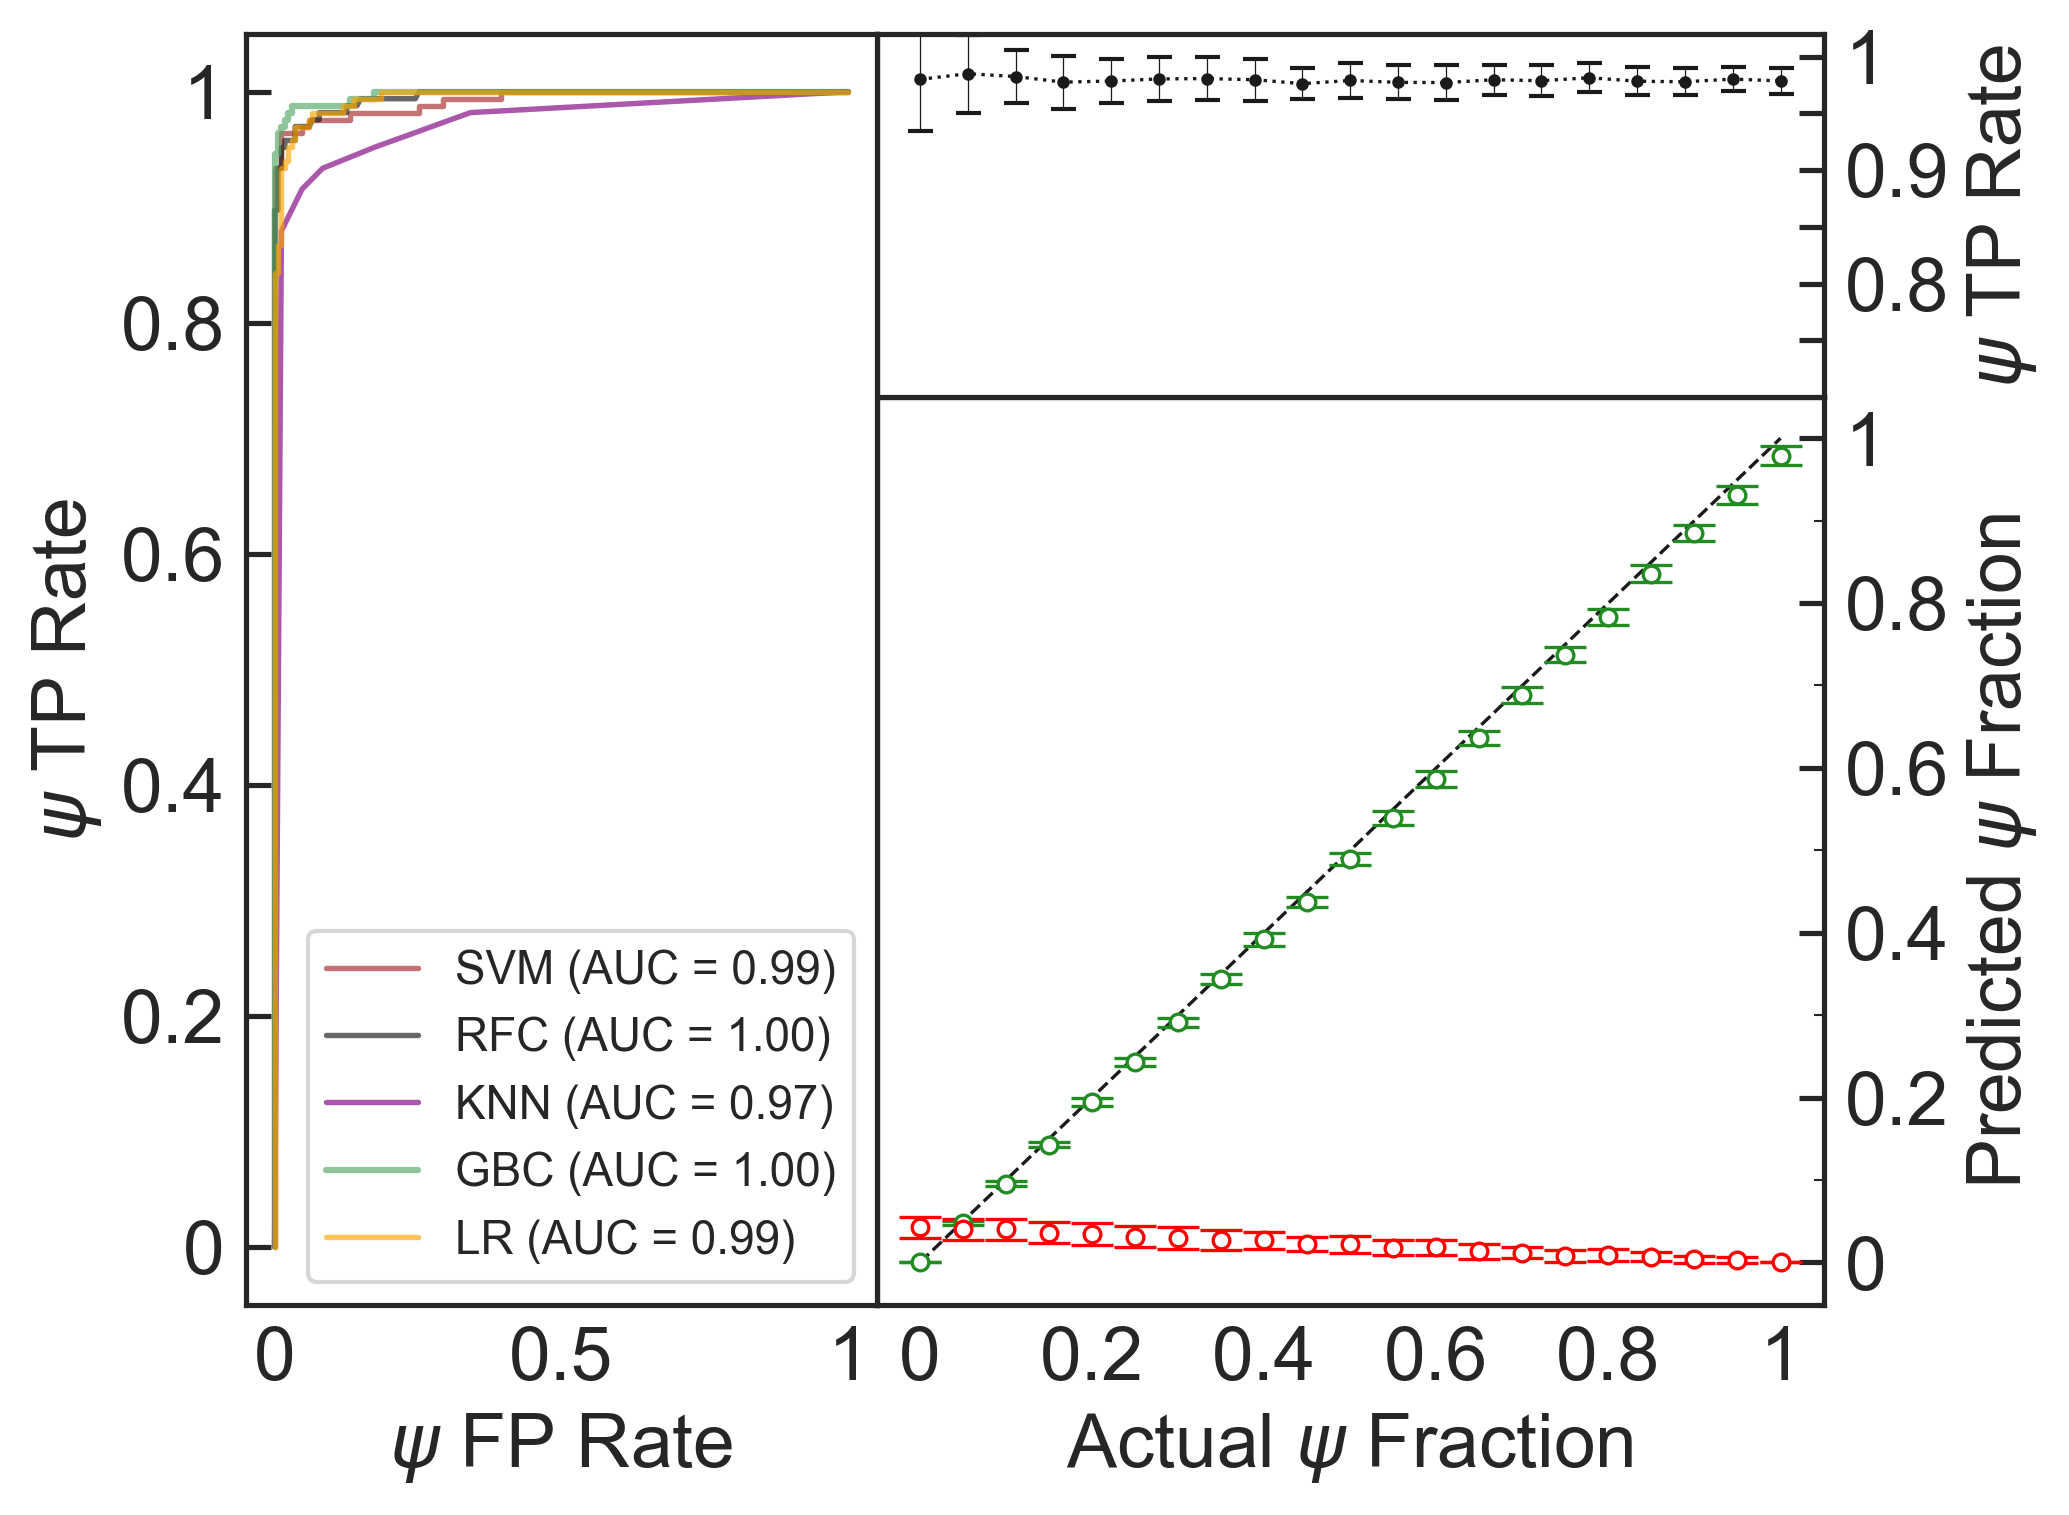

In [19]:
from sklearn.metrics import RocCurveDisplay
import seaborn as sns
from matplotlib import gridspec
import matplotlib.patches as mpatches
import matplotlib.font_manager
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import MultipleLocator
import matplotlib as mpl



plt.rcParams['font.family'] = "arial"
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
sns.set_style('white')

correct_mod_means=model_stats['modified']['positive_true_calls']['means']
correct_mod_stds=model_stats['modified']['positive_true_calls']['std_devs']
false_mod_means=model_stats['modified']['positive_false_calls']['means']
false_mod_stds=model_stats['modified']['positive_false_calls']['std_devs']

xval=range(0,21,1)
full_fig = plt.figure(figsize=(9.5,5.5),dpi=300)
gs=gridspec.GridSpec(7,7)
FalseModColor='red'
FalseControlColor='orange'
TrueModColor='forestgreen'
TrueControlColor='blue'
y_ideal=np.arange(0.0,1.05,0.05)
x_ideal=np.arange(0, len(y_ideal))

ax1=plt.subplot(gs[2:, 3:6])
ideal_plot, = ax1.plot(x_ideal,y_ideal,'--', color = 'k', linewidth=0.8, label=f"100% TP trend")
x_ticks = range(0,22,4)
ax1.set_xticks(x_ticks)
ax1.set_xticklabels(["0","0.2","0.4","0.6","0.8","1"],fontdict={'fontsize':18})
            
ax1.set_xlabel(r'Actual $\psi$ Fraction',fontdict={'fontsize' : 18})
ax1.set_ylabel(r'Predicted $\psi$ Fraction',fontdict={'fontsize':18})
y_ticks = np.arange(0.,1.1,0.2)
ax1.set_yticks(y_ticks)
ax1.set_yticklabels(["0", "0.2", "0.4", "0.6", "0.8", "1"], fontdict = {'fontsize' : 18})

ax1.errorbar(xval,correct_mod_means,yerr=correct_mod_stds,fmt='o',mfc='white',markeredgewidth=0.8,capsize=5,color=TrueModColor, 
             linestyle=None,markersize=4,capthick=0.5,elinewidth=0.5)
ax1.errorbar(xval,false_mod_means,yerr=false_mod_stds,fmt='o',mfc='white',markeredgewidth=0.8,capsize=5,color=FalseModColor, 
             linestyle=None,markersize=4,capthick=0.5,elinewidth=0.5)
ax1.yaxis.set_ticks_position("right")
ax1.yaxis.set_label_position("right")
ax1.tick_params(axis="y",direction="in",pad=5)
ax1.tick_params(axis="x",direction="in",pad=5)
minor_locator_x=AutoMinorLocator(2)
minor_locator_y=AutoMinorLocator(2)
ax1.tick_params(which='minor',length=2.5,width=0.5,direction='in')
ax1.xaxis.set_minor_locator(minor_locator_x)
ax1.yaxis.set_minor_locator(minor_locator_y)

##############################################
################TP-rate Plot##################
ax2 = plt.subplot(gs[0:2, 3:-1])
means=correct_mod_means=model_stats['modified']['positive_true_rate']['means'][1:-1]
stds=correct_mod_means=model_stats['modified']['positive_true_rate']['std_devs'][1:-1]
x_axis=range(0,21,1)
ax2.errorbar(x_axis[1:-1],means,yerr=stds,fmt='o',solid_capstyle='projecting', 
             capsize=3,color='k',linestyle=':',lw=0.8,markersize=2,elinewidth=0.3,label='TP rate')
y_ticks = np.arange(0.75,1.05,0.05)
ax2.set_yticks(y_ticks)
ax2.set_yticklabels([" ","0.8"," ","0.9"," ","1"," "], fontsize=18)
ax2.set_ylabel(r"$\psi$ TP Rate", fontdict = {'fontsize' : 18})#, fontsize=6, fontname="Lithos Pro")
ax2.set_xticklabels([])
ax2.yaxis.set_ticks_position("right")
ax2.yaxis.set_label_position("right")
ax2.tick_params(axis="y",direction="in", pad=5)
ax2.tick_params(axis="x",direction="in")
minor_locator_x = AutoMinorLocator(2)
minor_locator_y = AutoMinorLocator(2)
ax2.tick_params(which='minor', length=2.5, width=0.5, direction='in')
ax2.xaxis.set_minor_locator(minor_locator_x)
ax2.set_ylim(0.7, 1.02)

##############################################
##################ROC Plots###################
ax3 = plt.subplot(gs[:, 1:3])
gbc=summary_output_ratios['iteration_results'][0]['model']
x_train=summary_output_ratios['iteration_results'][0]['x_train_normalized']
y_train=summary_output_ratios['iteration_results'][0]['y_train']
x_test=summary_output_ratios['iteration_results'][0]['x_test_normalized']
y_test = summary_output_ratios['iteration_results'][0]['y_test']

from sklearn.preprocessing import Normalizer
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

####################################################################
rfc=RandomForestClassifier(n_estimators=200)
logisticRegr=LogisticRegression(solver='lbfgs')
knn=KNeighborsClassifier(n_neighbors=5)
svm=SVC(decision_function_shape='ovr',probability=True,kernel='rbf', 
        C=200,verbose=True,gamma='scale', class_weight = None)
#####################################################################
#####################################################################    
#Train the other models using the same training and test set
svm.fit(x_train,y_train)
rfc.fit(x_train,y_train)
knn.fit(x_train, y_train)
logisticRegr.fit(x_train, y_train)
#####################################################################

svc_disp=RocCurveDisplay.from_estimator(svm,x_test,y_test,ax=ax3,alpha=0.66,color='brown',linewidth=1.3,name='SVM')
rfc_disp=RocCurveDisplay.from_estimator(rfc,x_test,y_test,ax=ax3,alpha=0.66,color='k',linewidth=1.3,name='RFC')
knn_disp=RocCurveDisplay.from_estimator(knn,x_test,y_test,ax=ax3,alpha=0.66,color='purple',linewidth=1.3,name='KNN')
gbc_disp=RocCurveDisplay.from_estimator(gbc,x_test,y_test,ax=ax3,alpha=0.66,color='g',linewidth=1.5,name='GBC')
logisticRegr_disp=RocCurveDisplay.from_estimator(logisticRegr,x_test,y_test,ax=ax3,alpha=0.66,color='orange',linewidth=1.3,name='LR')
x_ticks=np.arange(0,1.02,0.5)
ax3.set_xticks(x_ticks)
ax3.set_xticklabels(["0", "0.5", "1"], fontdict = {'fontsize':18})
y_ticks = np.arange(0,1.02,0.2)
ax3.set_yticks(y_ticks)
ax3.set_yticklabels(["0", "0.2", "0.4", "0.6", "0.8", "1"],fontdict={'fontsize':18})
ax3.set_xlabel(r'$\psi$ FP Rate',fontdict={'fontsize':18})
ax3.set_ylabel(r'$\psi$ TP Rate',fontdict={'fontsize':18})
ax3.yaxis.set_ticks_position("left")
ax3.yaxis.set_label_position("left")
ax3.tick_params(axis="y",direction="in", pad=5)
ax3.tick_params(axis="x",direction="in", pad=5)
ax3.legend(loc="best",prop={'size':11})

plt.subplots_adjust(wspace=0, hspace=0)


### Now let's take all model iterations, re-correct for model error, and apply them onto native mRNA transcripts for site-specific ψ quantification

In [50]:
###Predict on Direct####
####Recorrection Based on ML True and False positive trend####
correct_mod_ratio_means=correct_mod_means=model_stats['modified']['positive_true_calls']['means']
false_mod_ratio_means = correct_mod_means=model_stats['modified']['positive_false_calls']['means']
correction_Sum = [x + y for x, y in zip(correct_mod_ratio_means, false_mod_ratio_means)] #combines TP/total test and FP/total test 
x_axis = np.arange(0.0,1.05,0.05)   
m,b=np.polyfit(x_axis, correction_Sum, 1) #Combined TP/total and FP/total correction


def recorrect_Func(raw_val,m,b):
    recorrected_result = (raw_val-b)/m 
    return recorrected_result


def model_pred(df:pd.DataFrame,model,scaler):
    assert('type' not in df.columns)
    x=scaler.transform(df)
    y_pred=model.predict(x)
    probability_scores = model.predict_proba(x)
    return {
        "prediction": y_pred,
        "scaled_x": x,
        "probability_scores":probability_scores
           }


import copy
def quantMod(df:pd.DataFrame,training_testing_iteration_results,correction_m,correction_b):
    ##unique_scalers=training_testing_iteration_results['unique_scalers']
    ##unique_models=training_testing_iteration_results['unique_models']
    unique_scalers=[result['scaler'] for result in training_testing_iteration_results]
    unique_models=[result['model'] for result in training_testing_iteration_results]
    predictions=[model_pred(df,model,scaler)['prediction'] for model,scaler in zip(unique_models,unique_scalers)]
    pred_counts=[dict(np.transpose(np.unique(pred,return_counts=True))) for pred in predictions]
    probability_scores=[model_pred(df,model,scaler)['probability_scores'] for model,scaler in zip(unique_models,unique_scalers)]
    pred_frac=copy.deepcopy(pred_counts)
    pred_frac_corrected=copy.deepcopy(pred_counts)
    for i,pred_count in enumerate(pred_counts):
        total=sum(pred_count.values())
        for key in pred_frac[i].keys():
            pred_frac[i][key]/=total
        if 'modified' not in pred_frac[i]:
            pred_frac_corrected[i]['modified']=recorrect_Func(0,correction_m,correction_b)
            pred_frac_corrected[i]['unmodified']=recorrect_Func(1,correction_m,correction_b)
            pred_frac[i]['modified'] = 0
        elif 'unmodified' not in pred_frac[i]:
            pred_frac_corrected[i]['modified']=recorrect_Func(1,correction_m,correction_b)
            pred_frac_corrected[i]['unmodified']=recorrect_Func(0,correction_m,correction_b)
            pred_frac[i]['unmodified'] = 0
        else:    
            pred_frac_corrected[i]['modified']=recorrect_Func(pred_frac[i]['modified'], correction_m, correction_b)
            pred_frac_corrected[i]['unmodified']=1.0-pred_frac_corrected[i]['modified']  
    
    mean_pred_fractions = {}
    std_pred_fractions = {}
    mean_pred_fractions_corrected = {}
    std_pred_fractions_corrected = {}
    
    for key in pred_frac[0].keys():
        print(key)
        mean_pred_fractions[key] = sum(d[key] for d in pred_frac) / len(pred_frac)
        std_pred_fractions[key] = np.std([d[key] for d in pred_frac])
    for key in pred_frac_corrected[0].keys():
        mean_pred_fractions_corrected[key] = sum(d[key] for d in pred_frac_corrected) / len(pred_frac)
        std_pred_fractions_corrected[key] = np.std([d[key] for d in pred_frac_corrected])

    return {"predictions":predictions,
            "pred_counts":pred_counts,
            "pred_probability_scores":probability_scores,
            "pred_fractions":pred_frac,
            "pred_fractions_corrected":pred_frac_corrected,
            "mean_pred_fractions": mean_pred_fractions,
            "std_pred_fractions": std_pred_fractions,
            "mean_pred_fractions_corrected":mean_pred_fractions_corrected,
            "std_pred_fractions_corrected": std_pred_fractions_corrected
           }


In [56]:
import glob
import pickle

gene="MCM5"
#gene="MRPS14"
#gene="PRPSAP1"
#gene="PSMB2"
#gene="RNF7"

cell_line="Direct" #Direct denotes HeLa cell line replicates
#cell_line="A549"
#cell_line="Hct116"
#cell_line="HepG2"
#cell_line="Hek293T"
#cell_line="HeLa"

#cell_line = "A549_direct"
#cell_line = "HepG2_direct"
#cell_line = "NTERA_direct"
#cell_line = "SH-SY5Y_direct"
#cell_line="IVT"

guppy_version = '6.3.2'
kmer_window = 'n5'

for idx, file in enumerate(glob.glob(f'prepared_direct_data/{gene}_{cell_line}*')):
##for idx, file in enumerate(glob.glob(f'ModQuant/prepared_SGNEx_data/{gene}_{cell_line}*')): #uncomment to predict on SGNEx-derived libraries
    print(idx, file)
    native_df=pd.read_pickle(file)
    native_df_features=native_df.loc[:, feature_space]
    print(f"n mRNA transcripts extracted for {gene}:{len(native_df_features)} reads")
    
    prediction_results=quantMod(native_df_features,summary_output_ratios['iteration_results'],m,b)
    print(f"Mean predictions:{prediction_results['mean_pred_fractions']}")
    print(f"Corrected predictions:{prediction_results['pred_fractions_corrected']}")
    print(".....")
    print(f"Corrected mean predictions:{prediction_results['mean_pred_fractions_corrected']}")
    print(".....")
    
    ###Uncomment to save model predicted quantification results###
    # file_name=f'Native_Quant_Results/{gene}_{cell_line}_replicate_{idx+1}_{guppy_version}_{kmer_window}_GBC_Quantification_Results'
    # with open(f'{file_name}.pkl','wb') as handle:
    #     pickle.dump(prediction_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

0 prepared_direct_data\MCM5_Direct1_data_with_insertions_6.3.2_n5_12112022_201558.pkl
n mRNA transcripts extracted for MCM5:39 reads
modified
unmodified
Mean predictions:{'modified': 0.5353846153846156, 'unmodified': 0.46461538461538426}
Corrected predictions:[{'modified': 0.47507018504770177, 'unmodified': 0.5249298149522983}, {'modified': 0.5841103338560788, 'unmodified': 0.4158896661439212}, {'modified': 0.5295902594518903, 'unmodified': 0.4704097405481097}, {'modified': 0.4205501106435134, 'unmodified': 0.5794498893564866}, {'modified': 0.44781014784560763, 'unmodified': 0.5521898521543924}, {'modified': 0.5568502966539846, 'unmodified': 0.44314970334601544}, {'modified': 0.4205501106435134, 'unmodified': 0.5794498893564866}, {'modified': 0.5568502966539846, 'unmodified': 0.44314970334601544}, {'modified': 0.5568502966539846, 'unmodified': 0.44314970334601544}, {'modified': 0.5568502966539846, 'unmodified': 0.44314970334601544}, {'modified': 0.5023302222497961, 'unmodified': 0.4976

### Since we have already predicted on all native mRNA transcripts from seven different cell lines, we can go ahead an plot all model-predicted results

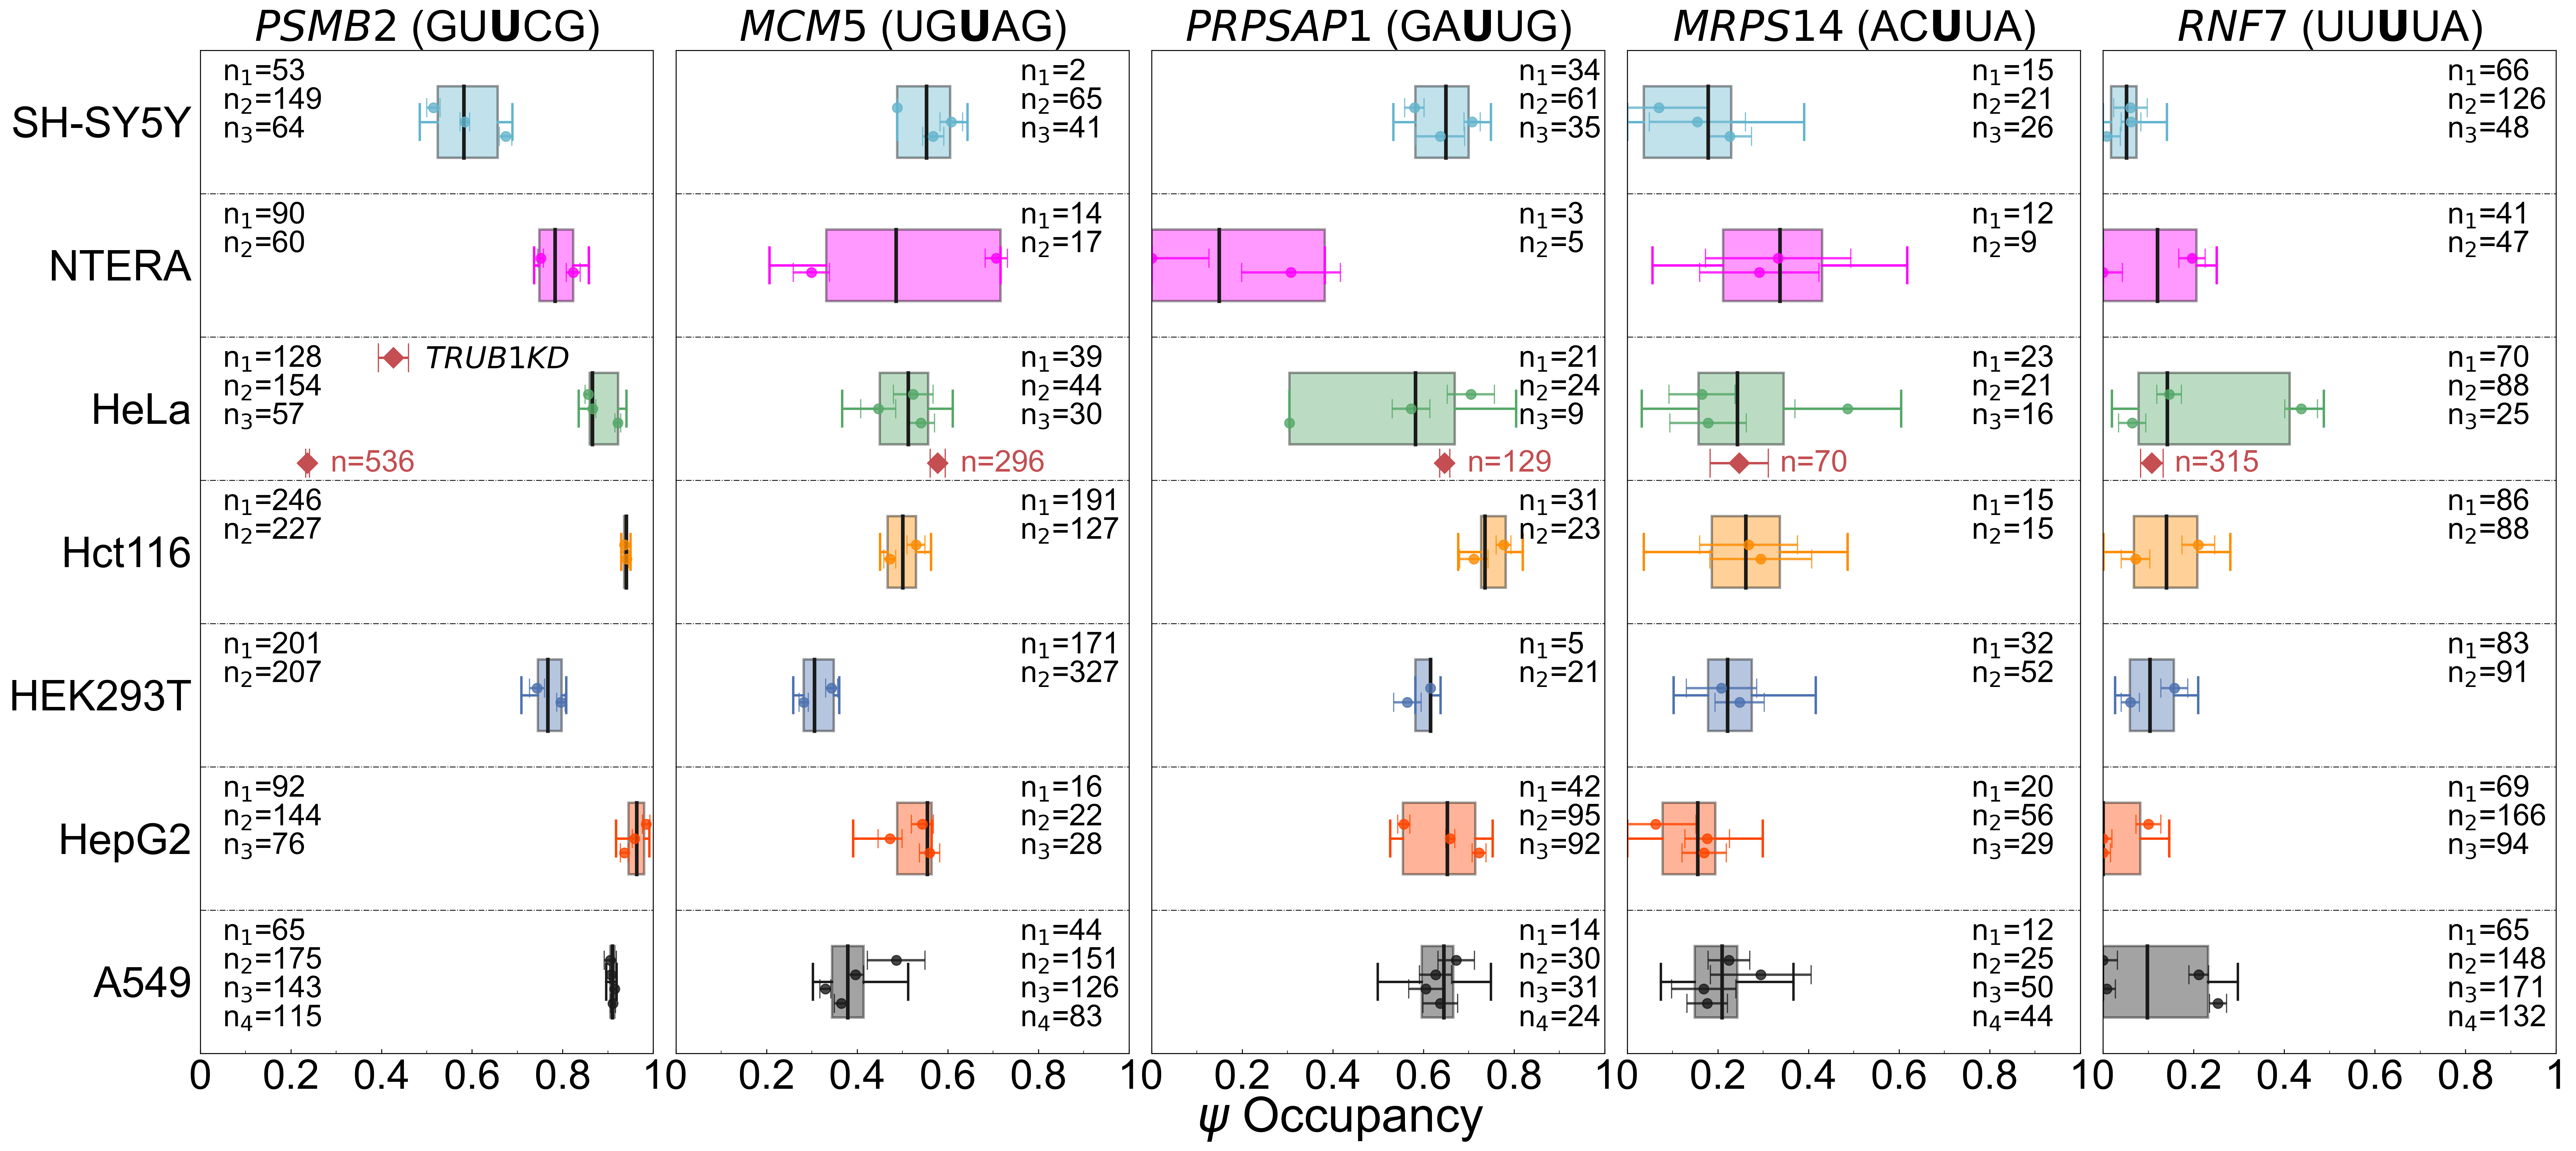

In [60]:
###Code to generate figure displaying quantification results with individual replicates shown as markers inside box and whiskers plot###
%matplotlib inline
import pickle
import scipy
import glob
plt.style.use('default')
plt.rcParams['font.sans-serif'] = 'Arial'

def plotQuant(mean,stdev,loc,ax,color,alpha,label):
    return ax.errorbar(mean,loc,xerr=stdev,fmt='o',solid_capstyle='projecting',capsize=8,color=color,linestyle=None,
               lw=1,alpha=alpha,markersize=8,elinewidth=2, label=f"{cell_line} $\mathrm{{\Psi}}$ Calls")


#Plotting Figure 4 Direct mRNA Psi Results#
PRPSAP1_KMER=r'GA' + r'$\bf{U}$' + r'UG' #PRPSAP1
MCM5_KMER=r'UG' + r'$\bf{U}$' + r'AG' #MCM5
MRPS14_KMER=r'AC' + r'$\bf{U}$' + r'UA' #MRPS14
PSMB2_KMER=r'GU' + r'$\bf{U}$' + r'CG' #PSMB2
RNF7_KMER=r'UU' + r'$\bf{U}$' + r'UA' #RNF7

kmer_list = [PSMB2_KMER,MCM5_KMER,PRPSAP1_KMER,MRPS14_KMER,RNF7_KMER]
gene_list = ['PSMB2','MCM5','PRPSAP1','MRPS14','RNF7']

##cell_lines = ["A549", "HepG2", "Hek293T", "Hct116", "HeLa_Direct", "NTERA", "SH-SY5Y"]
cell_lines = ["A549","HepG2","Hek293T","Hct116","HeLa","NTERA","SH-SY5Y"]

cell_line_labels = ["A549", "HepG2", "HEK293T", "Hct116", "HeLa", "NTERA", "SH-SY5Y"]
##cell_line_labels = ["A549", "HepG2", "Hek293T", "Hct116", "HeLa", "HeLa Trub1KD", "NTERA", "SH-SY5Y"]

x_ncount=[0.05, 0.76, 0.81, 0.76, 0.76]

colors = ["k","orangered","b","darkorange","g","magenta","c"]
##colors = ["k","darkred","b","r","g","purple","magenta","c"]

legend_handles=[]
jitter=0.1
step_sz=0.12

profileDf=pd.DataFrame(columns=["type","gene","pred_fractions_corrected"])
quantDf=pd.DataFrame(columns=["type","gene","file","replicate"])

fig,axs=plt.subplots(1,5, figsize=(35,15),dpi=300, sharex=True, sharey=True)

for gene_idx,(ax,gene,kmer) in enumerate(zip(fig.axes,gene_list,kmer_list)):
    x_ticks = np.arange(0,1.2,0.2)
    xmin=x_ticks[0]#-0.1
    xmax=x_ticks[-1]

    y_ticks = np.arange(0,len(cell_lines),1)
    ax.set_yticks(y_ticks)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(['0','0.2','0.4','0.6','0.8','1'], fontdict = {'fontsize' : 34})
    ax.set_title(f'$\it{gene}$ ({kmer})',fontdict = {'fontsize' : 35})#, fontdict
    for tick in y_ticks[:]:
        ax.hlines(tick-1, xmin, xmax, color='k', linestyle='-.', lw=0.75 )
    ax.set_ylim([-1, len(cell_lines)-1])
    ax.set_xlim([xmin, xmax])
    ax.tick_params(left = False)
    ax.tick_params(axis="x",direction="in", pad=5)
    ax.tick_params(which='minor', length=2.5, width=0.5, direction='in')
    minor_locator_x = AutoMinorLocator(2)
    ax.xaxis.set_minor_locator(minor_locator_x)
    quant_pred_results=[]
    for i,cell_line in enumerate(cell_lines):
        current_step=i-0.05
        if cell_line=='HeLa':
            n_exps=len(glob.glob(f'Native_Quant_Results/{gene}_{cell_line}_[!IVT]*'))
        else:
            n_exps=len(glob.glob(f'Native_Quant_Results/{gene}_{cell_line}*'))
        mf=[]
        cell_line_mf=[]
        positions=[]
        
        for n,file in enumerate(glob.glob(f'Native_Quant_Results/{gene}_{cell_line}_[!IVT]*')):
            d={"type":cell_line,
               "gene":gene,
               "file":file,
               "replicate":n}
            with open(file, 'rb') as handle: 
                prediction_results=pickle.load(handle)
                sample_sz=len(prediction_results['predictions'][0])
                d["sample_sz"]=sample_sz
                for mod_fracs in prediction_results["pred_fractions_corrected"]:
                    if mod_fracs['modified']<0:
                        mod_fracs['modified']=0
                    mf.append(mod_fracs['modified'])
                mean_corrected_result=prediction_results["mean_pred_fractions_corrected"]["modified"]
                if mean_corrected_result<0:
                    mean_corrected_result=0
                std_corrected_result=prediction_results["std_pred_fractions_corrected"]["modified"]
                d["mean_corrected_prediction"]=mean_corrected_result
                d["std_corrected_prediction"]=std_corrected_result
                if n==0:
                    loc=current_step-jitter
                else:
                    loc=loc-jitter
                if n_exps==2:
                    add_step=0.3
                elif n_exps==3:
                    add_step=0.25
                elif n_exps==4:
                    add_step=0.2
                else:
                    add_step=0.2  
                quantDf=pd.concat([quantDf,pd.DataFrame([d])],ignore_index=True)

        start_box=current_step
        end_box=loc+jitter
        delta=(end_box-start_box)/2
        position=i-0.5#0.75
        positions.append(position)
        ax.boxplot(mf,widths=0.5,positions=positions,vert=0,manage_ticks=False,autorange =True,showfliers=False,showcaps=True,patch_artist=True,
                    boxprops=dict(alpha=0.4,facecolor=colors[i],linewidth=2),
                    capprops=dict(color=colors[i],linewidth=2),
                    whiskerprops=dict(color=colors[i],linewidth=2),
                    medianprops=dict(color='k',linewidth=3))
        cell_line_mf+=mf
        quant_pred_results.append(cell_line_mf)

        for n,file in enumerate(glob.glob(f'Native_Quant_Results/{gene}_{cell_line}_[!IV]*')):
            d={"type":cell_line,
               "gene":gene,
               "file":file,
               "replicate":n}
            with open(file, 'rb') as handle: 
                prediction_results=pickle.load(handle)
                sample_sz=len(prediction_results['predictions'][0])
                d["sample_sz"]=sample_sz
                for mod_fracs in prediction_results["pred_fractions_corrected"]:
                    if mod_fracs['modified']<0:
                        mod_fracs['modified']=0
                    mf.append(mod_fracs['modified'])
                mean_corrected_result=prediction_results["mean_pred_fractions_corrected"]["modified"]
                if mean_corrected_result<0:
                    mean_corrected_result=0
                std_corrected_result=prediction_results["std_pred_fractions_corrected"]["modified"]
                d["mean_corrected_prediction"]=mean_corrected_result
                d["std_corrected_prediction"]=std_corrected_result
                if n==0:
                    loc=current_step-jitter
                    prev_mean_corrected_result=mean_corrected_result
                else:
                    loc=loc-jitter
                    quant_diff=np.absolute(mean_corrected_result-prev_mean_corrected_result)
                if n_exps==2:
                    add_step=0.3
                elif n_exps==3:
                    add_step=0.25
                elif n_exps==4:
                    add_step=0.2
                else:
                    add_step=0.2

                if 'Trub1KD' in file:
                    x_ncount_tkd=[0.05, 0.05, 0.05, 0.09, 0.05]
                    quantplot=ax.errorbar(mean_corrected_result,loc-0.43,xerr=std_corrected_result,
                                          fmt='D',solid_capstyle='projecting',capsize=12,color='r',linestyle=None,
                                          lw=1,alpha=1,markersize=12,elinewidth=2, label="$\itTRUB1KD$")
                    ax.text(mean_corrected_result+x_ncount_tkd[gene_idx], loc-0.49, f'n={sample_sz}', color='r', fontdict = {'fontsize' : 25}, ha='left') 
                    if gene=='PSMB2':
                        legend_handles.append(quantplot)
                        ax.legend(handles=legend_handles,bbox_to_anchor=(0.3,0.65,0.6,0.2),frameon=False, handletextpad=0.06, loc='lower left', fontsize=25)
                    
                else:
                    quantplot=plotQuant(mean_corrected_result,std_corrected_result,loc-add_step,ax,colors[i],0.8,cell_line)
                    ax.text(x_ncount[gene_idx], current_step-n*2*jitter-0.16, f'n$_{n+1}$={sample_sz}', fontdict = {'fontsize' : 25}, ha='left') 

              
        s={"type":cell_line,
           "gene":gene,
           "pred_fractions_corrected":cell_line_mf}
        profileDf=pd.concat([profileDf,pd.DataFrame([s])],ignore_index=True)
   
y_ticks = np.arange(0,len(cell_lines),1)-0.5
ax.set_yticks(y_ticks)
fig.axes[0].set_yticklabels(cell_line_labels, fontdict = {'fontsize' : 35})
    
fig.text(0.5, 0.05, f'$\psi$ Occupancy', fontdict = {'fontsize' : 40}, ha='center') 
plt.subplots_adjust(wspace=0.05, hspace=0)

